### Explainable Machine Learning

이번 주차에서는 머신러닝이 이론의 개발을 연구하는 연구자들에게 직관적이고 효과적인 도구를 제공해준다는 몇 가지 모델들에 대해 소개한다

#### 1. Feature Importance

전통적으로 변수의 유의성과 설명력은 p-value에 의존해왔다. 변수의 수가 증가하고 데이터의 크기가 커지면서 p-value에 대한 추정의 불안정성이 대두되었고, 그 대안으로 나온 metric이 바로 Feature Importance이다. data generating을 통해 p-value와 feature importance를 비교하고 machine learning의 whitening에 대해서 간략히 다뤄보도록 한다

다음 함수는 informative, redundant, noise feature를 생성하는 함수이다. 각각의 feature는 다음과 같은 특징을 갖는다

1. informative : label 예측에 있어서 실질적으로 가장 고유하고 독립적인 정보를 제공하는 feature
2. redundant : label 예측에 있어서 중요한 정보를 제공하긴 하지만, feature간 다중공선성이 존재하는 feature
3. noise : label 예측에 있어서 거의 아무런 영향을 주지 않는 feature

In [1]:
import pandas as pd
import numpy as np

def get_test_data(
        n_features : int = 40,
        n_informative : int = 10,
        n_redundant : int = 10,
        n_samples : int = 10000,
        random_state : int = 42,
        sigma_std : float = 0.0
) : 
    from sklearn.datasets import make_classification
    
    np.random.seed(random_state)
    
    trnsX, cont = make_classification(
        n_samples = n_samples,
        n_features = n_features,
        n_informative = n_informative,
        n_redundant = n_redundant,
        random_state = random_state,
        shuffle = False
    )
    
    df0_index = pd.date_range(start = pd.to_datetime('today') - pd.to_timedelta(n_samples, unit = 'd'), 
                              periods = n_samples, freq = 'B')

    trnsX, cont = pd.DataFrame(trnsX, index = df0_index), pd.Series(cont, index=df0_index).to_frame('bin')

    df0 = ['I_' + str(i) for i in range(n_informative)] + ['R_' + str(i) for i in range(n_redundant)]
    df0 += ['N_' + str(i) for i in range(n_features - len(df0))]
    
    trnsX.columns = df0
    cont['w'] = 1. / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index = cont.index)
    
    return trnsX, cont

전체 feature는 20개, informative는 5개, redundant feature는 5개로 지정한다. noise는 자동적으로 10개가 된다. 관측치의 수는 1000개로 generating한다

In [2]:
trnsX, cont = get_test_data(n_features = 20, n_informative = 5, n_redundant = 5, n_samples = 1000)

**1.1 $p-\mathrm{value}$**

고전적 회귀 분석 framework는 올바른 모델 사양, 상호 상관없는 회귀 분석기 또는 백색 잡음 잔차 등, 적합화된 모델에 관한 여러가지 가정을 한다. 그러한 가정이 사실이라는 것을 전제로, 연구자들은 가설 검정을 통해 설명 변수의 중요도를 결정하고자 노력해 왔다. 변수의 중요도와 설명력을 표현하는 일반적인 방법은 1700년대에 제안된 개념인 p-value가 있다

$$p-\mathrm{value} = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$$

p-value는 해당 변수와 관련된 실제 계수가 0일 떄 우리가 추정했던 것과 같거나 더 극단적인 결과를 얻었을 확률을 계량화한다. 이는 데이터가 설정된 통계 모형과 얼마나 일치하지 않는지를 나타낸다. 그러나, p-value는 귀무가설이나 대립가설이 참이 아니거나 데이터가 랜덤일 확률을 측정하지 않는다. 또한, p-value의 오용은 매우 광범위하게 퍼져 있을 뿐만 아니라, 지난 수십년간의 금융 연구에서의 신뢰도 문제를 불러일으킨다

실제로 p-value의 가장 큰 담점은, 그 값의 근거가 매우 강력한 가정에 의존한다는 것이다. 그러한 가정들이 하나라도 빗나갈 때, false positive와 false negative로 나타날 가능성이 높아진다. 이러한 이유 때문에, 2019년 미국 통계협회에서는 통계적 유의성의 척도로서 p-value의 적용을 권장하고 있지 않다(Wasserstein et al. 2019)

p-value의 두 번째 단점은 높은 multicollinearity를 가지고 있는 변수들에 대해서 p-value를 강건하게 추정할 수 없다는 것이다. 다중공선성이 존재하는 상황에서 전통적 회귀 분석 방법은 중복된 정보를 구별할 수 없으므로, p-value간의 대체효과가 발생해 실제 값보다 부풀려지는 결과가 나올 수 있다

p-value의 세 번째 단점은 완전히 관련이 없는 확률을 평가한다는 것이다. 귀무가설 $H_0$와 추정된 계수 $\hat{\beta}$이 주어졌을 때, p-value는 $H_0$이 참인 경우 $\hat{\beta}$과 같거나 극단적인 결과를 얻을 확률을 추정한다. 그러나, 연구자들은 종종 다른 확률, 즉 $\hat{\beta}$을 관찰했을 때 $H_0$이 참일 확률에 더 관심이 있다. 이 확률은 Bayes theorem을 이용해 계산할 수 있으며, 주변분포에 대해 가정을 해야 구할 수 있다.

p-value의 네 번째 결함은 샘플의 유의성을 평가한다는 것이다. 전체 샘플은 계수 추정과 유의성 결정이라는 두 가지 과제를 해결하는데 사용된다. 따라서, p-value는 샘플 외 설명값이 없는 변수에 대해 낮을 수 있다. 동일한 데이터셋에 대해 여러 번의 샘플 내 테스트를 진행하면 잘못된 발견을 할 가능성이 높아지며, 이는 통계적 사기이다

요약하자만, p-value는 필요 이상의 너무 많은 가정을 요구하기 때문에 변수가 여러개인 모형에는 알맞지 않으며, 유의성을 추정하기에도 적절치 않은 값이다. 아래 예를 통해 p-value가 어떻게 정보를 희석시키는지 알아보도록 한다

In [3]:
import statsmodels.api as sm
ols = sm.Logit(cont['bin'], trnsX).fit()

         Current function value: 0.438438
         Iterations: 35


/Users/junghunlee/anaconda3/envs/TimeSeriesModeling/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'p-values')

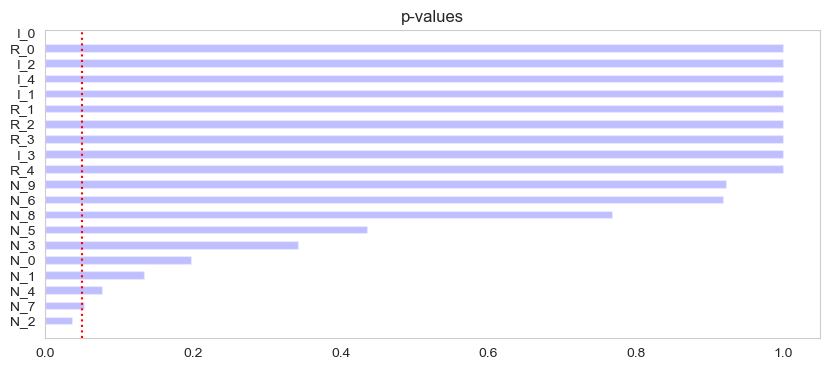

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 4))
plt.barh(
    ols.pvalues.sort_values(ascending = True).index, 
    ols.pvalues.sort_values(ascending = True), 
    color = 'b', alpha = 0.25, height = 0.5
)
plt.axvline(0.05, ls = ':', color = 'r')
plt.grid(False)
plt.title('p-values')

**1.2 Mean Decrease Importance**

F개의 특성과 관찰당 하나의 레이블로 구성된 크기 N개의 학습 샘플을 갖고 있다고 가정하자. Tree Model을 기반으로 하는 분류/회귀 알고리즘은 각 노트 $t$에서 label을 2개의 샘플로 분할한다. 주어진 feature $X_f$에 대해 임의의 threshold $\tau$이하의 $X_f$와 연관된 노드 $t$의 label은 왼쪽 샘플에 배치하고, 나머지는 오른쪽 샘플에 배치한다. 이를 분기라고 하며, Tree를 기반으로 하는 Random Forest, XG Boost, Cat Boost등 대부분의 Ensemble Model이 이러한 분기의 과정을 거친다

각 샘플에 대해 label값의 분포의 Entropy, Gini impurity 혹은 이외의 기준을 따라서 불순도를 평가할 수 있다. 직관적으로, 샘플은 한 종류의 label만을 담았을 때 가장 순수하며, label이 균등 분포를 따를 때 가장 impurity가 높다고 할 수 있다. 분할에 의해 얻을 수 있는 정보 이득은 아래와 같이 불순도의 감소로 측정된다

$$\Delta g(t, f) = i(t) - \frac{N_t^{(0)}}{N_t}i(t^{(0)}) - \frac{N_t^{(1)}}{N_t}i(t^{(1)})$$

여기서 $i(t)$는 노드 $t$에서의 label의 불순도이고, $i(t^{(0)})$는 왼쪽으로 분기된 샘플의 불순도, $i(t^{(1)})$은 오른쪽으로 분기된 샘플의 불순도이다

각 노드 $t$에서 분류모형은 $\{X_f\}_{1, \dots, F}$의 다양한 feature에 대해 $\Delta g(t, f)$를 평가하고, 이들 각각에 대해 $\Delta g(t, f)$를 최대화하는 최적 임계값 $t$를 결정하고, 최대 $\Delta g(t, f)$와 연관된 특성을 선택한다. 분류 알고리즘은 더 이상의 Information Gain(정보 이득)이 발생하지 않거나 최대 허용 한도 미만으로 불순도를 달성하는 등의 조기 종료 조건이 충족될 때까지 샘플을 분기한다

Feature Importance는 특성이 선택된 모든 노드에서 Weighted Information Gain(가중 정보 이득)으로 계산할 수 있다. Mean Decrease Impurity는 특성이 얼마나 불순도를 줄여주는데 기여를 하는지 보여주는 지표이며, 모든 특성의 중요도의 합은 1로 계산된다. 동등한 정보를 가진 feature가 $F$개 있으면 각 feature의 중요도는 $\frac{1}{F}$일 것으로 기대된다

sklearn에서 Random Forest와 같은 앙상블 모형은 다음과 같은 방법으로 MDI feature importance를 추정하는 method가 기본적으로 탑재되어 있다

```
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
```

importance 추정치는 계량경제학 모형의 beta (coefficient) 추정치와 대응되며, std는 변수의 t-distribution을 추정하는 것과 유사하다. 즉, feature importance는 하나의 parameter로 작용 가능하다

한편, 우리는 시계열 모형에 대해서 다루므로, 다음과 같이 시간적 정보의 중복을 제거한 feature importance를 사용하도록 한다

In [5]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from feature_importances import *

분류기는 다음과 같이 RandomForest를 사용한다. feature에는 trnsX를 사용하고, target은 1과 0으로 이뤄진 binary label을 사용한다

In [6]:
forest = RandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.0,
    random_state = 42,
    n_estimators = 1000,
    max_features = 3,
    oob_score = True,
    n_jobs = 1
)

fit = forest.fit(X = trnsX, y = cont['bin'])
oob_score = fit.oob_score_

`PurgedKFold`를 사용해 순차적 특성을 고려하여 K-fold 교차검증을 수행해 준다. 여기서 `cont['t1']`은 포지션을 가지고 있는 만기로 이뤄진 pandas.Series이다

In [7]:
cv_gen = PurgedKFold(n_splits = 5, samples_info_sets = cont['t1'])

아래와 같이 `ml_cross_val_score`를 이용해 out of sample(oos) score를 추정한다

In [8]:
oos_score = ml_cross_val_score(forest, trnsX, cont['bin'], cv_gen = cv_gen, scoring = accuracy_score).mean()

`mean_decrease_impurity`를 사용하면 feature importance를 구할 수 있다

In [9]:
mdi = mean_decrease_impurity(fit, trnsX.columns)

In [10]:
mdi

,mean,std
I_0,0.149770,0.004193
I_1,0.039976,0.000987
I_2,0.037874,0.000982
I_3,0.077811,0.002873
I_4,0.060974,0.001408
R_0,0.036944,0.001032
R_1,0.104822,0.003300
R_2,0.057928,0.001402
R_3,0.186117,0.004794
R_4,0.100448,0.003100


`plot_feature_importance`를 이용해 특성 중요도를 확인해 보자. OOB score는 0.935, OOS score는 0.827이다

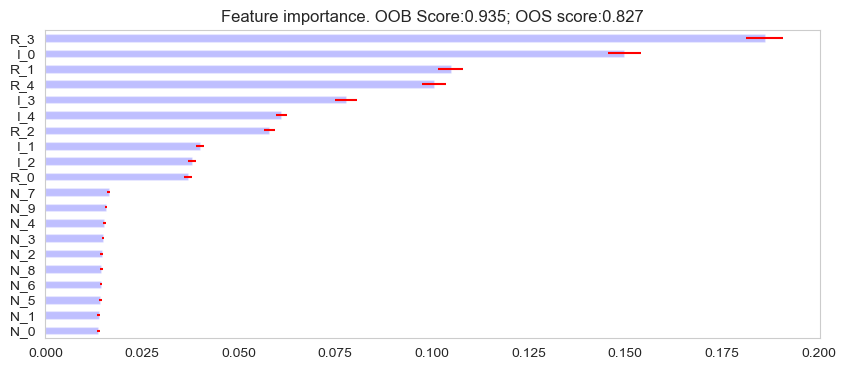

In [11]:
plot_feature_importance(
    mdi,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDI_feature_importance.png'
)
plt.grid(False)
plt.show()

p-value의 결과와 비교해 봤을때, Noise가 모두 하위에 랭크된 것을 볼 수 있다. 모델 학습에 있어서 정보를 가지고 있는 information과 redundant feature들이 중요도가 높게 나온 것을 알 수 있다

MDI feature importance는 다음과 같은 장점이 존재한다

1. MDI는 계산하는 데 있어서 변수의 강력한 분포적 가정을 요구하지 않는다. 즉, 변수의 분포는 어떤 모양을 해도 상관없다
2. 통계모형의 beta는 단일 샘플에 대해 추정되는 반면, ensemble모형의 MDI feature importance는 Bootstrapping을 통해 도출된다. 따라서, 추정치의 분산은 ensemble추정기의 개수를 증가시킴으로써 줄일 수 있다
3. Base Model이 Tree인 분류기의 목적은 주어진 대수 방정식의 계수를 추정하는 것이 아니므로 특정 귀무가설의 확률을 추정하는 것과는 무관하다. 따라서, 추정기에서 실질적으로 도움이 된 특성을 찾아 점수를 매겨준다

다만, MDI는 어디까지나 sample내에서 계산된다는 점에서 과적합의 여지가 존재한다. 이후 소개하는 **MDA feature importance**는 이러한 단점을 보완해 준다

**1.3 Mean Decrease Accuracy**

p-value와 MDI 모두 설명 목적으로 샘플 내에서 유의적으로 보이는 변수가 예측의 목적과 무관할 수 있다는 점이다. 이 문제를 해결하고자, MDA 특성 중요도가 제안되었다

MDA는 다음과 같이 동작한다. 
1. 모델을 적합화시키고 교차 검증된 성과를 계산한다
2. 동일한 적합화 모델읠 교차 검증된 성과를 하는데, 단 하나의 차이점은 feature 중 하나와 관련된 관찰값들을 셔플링한다는 것ㅇ디ㅏ. 그것은 특성당 하나의 수정된 교차검증 성능을 제공한다
3. 셔플링 전후의 교차 검증된 성능을 비교함으로써, 특정 feature와 연관된 MDA score를 도출한다. **특성이 중요하다면 특성이 독립인 경우, 셔플링으로 인해 성과의 현저한 저하 현성이 있어야 한다**

MDA의 중요한 속성은 MDI와 마찬가지로 단일 추정치의 결과가 아닌 여러개의 추정치의 평균이라는 것이다. 일반적으로, MDA feature importance는 **순열 중요 (permutation importance)** 로 많이 불리며, 다음과 같이 구현된다

```
from sklearn.inspection import permutation_importance
r = permutation_importance(
    model, X_val, y_val,
    n_repeats=30,
    random_state=0
)
```

우리는 시간의 순서가 중요한 시계열 데이터를 다루고 있으므로 permutation importance를 그대로 쓰는것 보다는 아래 예제의 MDA 특성 중요도를 사용하도록 하자

한가지 중요한 점은, feature가 독립적이지 않은 경우 MDA는 상호 관련 특성의 중요성을 과소평가할 수 있다. 극단적으로, 매우 중요하지만 동일한 두가지 feature를 고려할 때, MDA는 한 가지 feature를 셔플링하는 효과가 동인한 다른 feature의 존재로 인해 상쇄될 수 있기 때문에, 두 feature모두 중요하지 않다고 결론내릴 수 있다.아래의 예시를 보고, 이러한 점을 확인해 보자

In [12]:
mda = mean_decrease_accuracy(fit, trnsX, cont['bin'], cv_gen, scoring = accuracy_score)

MDA는 이름에 accuracy가 들어감에도 불구하고, 성능 기준을 accuracy로 꼭 할 필요는 없다. mda는 다른 성과 점수로 계산이 가능함으로 참고하자

In [13]:
mda

,mean,std
I_0,0.132141,0.228427
I_1,0.104274,0.027225
I_2,0.111496,0.051622
I_3,0.142856,0.065140
I_4,0.133888,0.048109
R_0,0.072527,0.063761
R_1,0.126855,0.061873
R_2,0.155045,0.029027
R_3,0.391615,0.112170
R_4,0.131732,0.051068


MDA를 위와 같이 구할 수 있다. MDI에서 추정한 mean과 std와 비슷한 기능을 한다

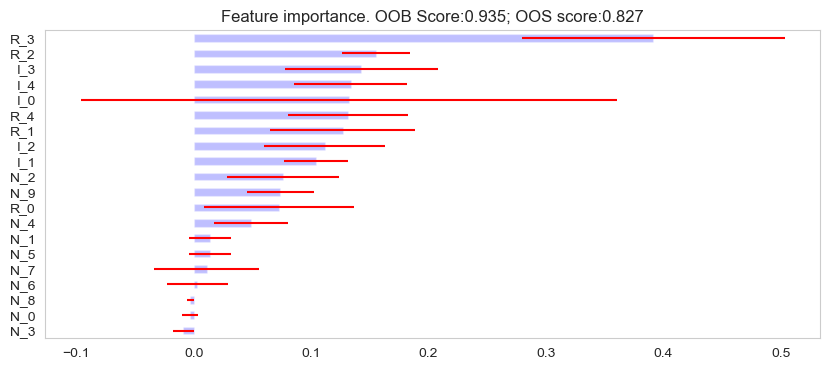

In [14]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDA_feature_importance.png'
)
plt.grid(False)
plt.show()

plotting은 위와 같이 표현될 수 있다

**1.4 Alternative Metrics**

금융 응용에서 정확도에 대한 좋은 대안은 로그 손실이다. 로그 손실은 True Label의 평균 로그 우도 측면에서 분류기를 점수화한다. 그러나 한 가지 단점은 log 손실을 해석하고 비교하기가 쉽지 않다는 점이다. 한 가지 방법은, True Label의 **음의 평균 우도(Negative Average Likelihood)** 를 계산하는 것이다

$$\mathrm{NegAL} = -N^{-1} \sum_{n=0}^{N-1} \sum_{k=0}^{K-1} {y_{n,k} p_{n,k}}$$

여기서 $p_{n,k}$는 label $k$의 예측 $n$과 관련된 확률이며, $y_{n,k}$는 지표 함수, $y_{n,k} \in \{ 0,1 \}$이다. 또한, 관찰 $n$이 label $k$에 할당됐을 때는 $y_{n,k} = 1$이고, 할당되지 않았을 때에는 $y_{n,k} = 0$이다. 이는 로그 손실과 매우 유사하나, 로그 우도가 아니라 우도의 평균을 한다는 점에서 다르며, Negative Average Liklihood의 범위는 여전히 0과 1 사이이다

또는, **확률 가중 정확도(PWA, Probability-Weighted Accuracy)** 를 사용할 수도 있다

$$\mathrm{PWA} = \frac{\sum_{n = 0}^{N-1} y_n(p_n - K^{-1})}{\sum_{n = 0}^{N-1} (p_n - K^{-1})}$$

여기서 $p_n = \max_k{\{p_{n,k}\}}$이고 $y_n$은 지표 함수, $y_{n,k} \in \{ 0,1 \}$이며, 예측이 정확할 때 $y_n = 1$이고 아니면 $y_n = 0$이다. 이는 분류기가 모든 예측에 절대적인 확신을 가질 때의 표준 정확도와 동일하다. 확률 가중 정확도는 높은 신뢰도를 가지고 한 잘못된 예측에 대해 정확도보다 더욱 심하게 패널티를 가하는데, 로그 손실보다는 덜 심하게 패널티를 가한다

여기에서는 sklearn의 log_loss를 사용하여 MDA Feature Importance를 계산해 본다

In [15]:
from sklearn.metrics import log_loss

mda = mean_decrease_accuracy(fit, trnsX, cont['bin'], cv_gen, scoring = log_loss)

scoring을 log_loss로 지정하여 계산해 본다

In [16]:
mda

,mean,std
I_0,0.178104,0.073623
I_1,0.047096,0.051199
I_2,0.039898,0.012445
I_3,0.064785,0.026054
I_4,0.098722,0.042837
R_0,0.031393,0.013293
R_1,0.113175,0.036094
R_2,0.051282,0.071104
R_3,0.224791,0.090765
R_4,0.085424,0.033060


noise에 대한 feature가 획기적으로 줄어든 것을 확인할 수 있다

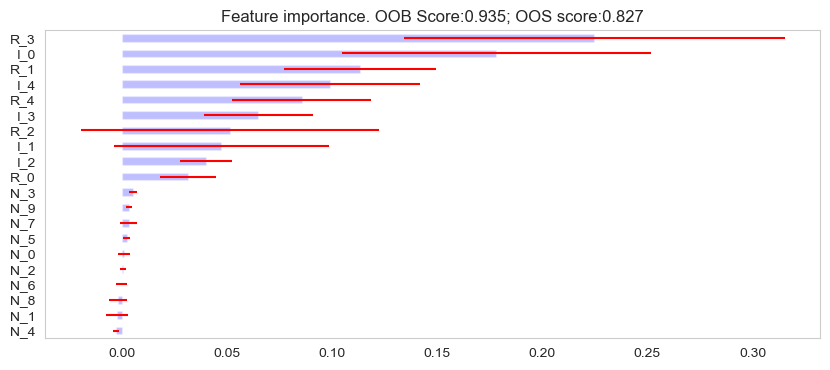

In [17]:
plot_feature_importance(
    mda,
    oob_score = oob_score,
    oos_score = oos_score,
    save_fig = True,
    output_path = './MDA_feature_importance_logloss.png'
)
plt.grid(False)
plt.show()

plotting 결과에서도 동일하게 noise feature들이 줄어든 것을 확인할 수 있다. 이는 전략을 설정하는데 있어서 획기적인 insight를 제공해 준다

#### 2. Shapley Value

Machine Learning의 복잡한 기여도를 계산하기 위한 또 다른 방법은 바로 Shapley Value를 사용하는 것이다. Lloyd Shapleyrk가 1953년 제안한 개념으로, **협력 게임이론에서 전체 이익을 플레이어 각각의 기여도에 맞게 이익을 분배**하는 방법이다. 게임이론에서 차용된 개념이기 때문에, Machine Learning 모형에 맞춰 재정의할 필요가 있다.

- Game : 데이터셋에서 단일 instance에 대한 예측
- Gain : 해당 단일 instance에 대한 예측값에서 전체의 평균 예측값을 뺀 것
- Players : 해당 단일 instance의 feature

즉, Shapley Value는 모든 가능한 feature 부분 집합에 대한 평균적인 이익의 기여도로 해석할 수 있다. 여기서는 각 feature가 예측값에 기여한 정도를 계산한 것이라고 생각하면 된다

선형 모형을 다음과 같이 가정해 보자. 여기서 $x$는 하나의 instance이다

$$\hat{f}(x) = \beta_0 + \beta_1 + \cdots + \beta_p x_p$$

예측값 $\hat{f}(x)$에 대한 $j$번째 feature의 기여도 $\phi_j$는 다음과 같다

$$\phi_j(\hat{f}) = \beta_j x_j - E(\beta_j X_j) = \beta_j x_j - \beta_j E(X_j)$$

하나의 instance에 대해 모든 feature의 기여도를 합치면 예측값에서 전체 데이터의 예측값 평균을 뺀 것과 같다

$$
\begin{matrix}
\sum_{j=1}^p \phi_j(\hat{f}) & = & \sum_{j=1}^p \left( \beta_j x_j - E(\beta_j X_j)\right) \\
       & = & \left( \beta_0 + \sum_{j=1}^p \beta_j x_j \right) - \left( \beta_0 + \sum_{j=1}^p E(\beta_j X_j)\right) \\
       & = & \hat{f}(x) - E(\hat{f}(X))
\end{matrix}
$$

Shapley value는 플레이어들의 가치 함수(value function)를 사용하여 정의한다. Shapley value를 머신러닝에 맞춰 설명한다면, 피처의 Shapley value는 가능한 모든 가능한 피처 조합들의 기여도들의 가중치 합이다

모델에 사용한 피처들의 부분 집합 $S$, 피처의 개수 $p$에 대해서 다음과 같이 정의한다

$$\phi_j(\mathrm{value}) = \sum_{S \subseteq \{1, \cdots, p\} \setminus \{j\}}
\frac{|S|!(p - |S| - 1)!}{p!}(\mathrm{value}(S \cup \{j\}) - \mathrm{value}(S)) $$

데이터 instance의 feature vector $x$에 대해서 가치 함수 $\mathrm{value}_x(S)$는 다음과 같이 정의한다

$$\mathrm{value}_x(S) = \int \hat{f}(x_1, \cdots, x_p) d\mathbb{P}_{x \notin S} - E_X(\hat{f}(X))$$

**2.1 Shapley Value의 네 가지 특성**

1. 모든 $j$에 대해서 $ϕ_j$의 합은 항상 예측값에서 전체 예측값의 평균을 뺀 것과 같아진다. 더 엄밀하게 말하자면 가치 함수와 같아진다

$$\sum_{j=1}^p \phi_j = \hat{f}(x) - E_X(\hat{f}(X))$$

2. 만약 두 feature $j$와 $k$가 모든 부분집합 $S$에 들어가지 않고 두 feature를 각각 포함한 가치 함수가 같다면 두 피처의 기여도는 반드시 같다
3. feature $j$가 예측값에 영향을 미치지 않는다면 feature $j$에 대한 Shapley value는 반드시 0이다
4. Shapley value는 다음의 성질을 만족한다

$$\phi_j(\mathrm{value} + \mathrm{value}^+) = \phi_j(\mathrm{value}) + \phi_j(\mathrm{value}^+)$$
$$\phi_j(a \times \mathrm{value}) = a \cdot \phi_j(\mathrm{value})$$

**2.2 SHAP Model**

SHAP Model은 2017년 제안된 모형으로, Shapley Value를 기반으로 한 설명 기법이다. 모형은 다음과 같이 계산된다

$$g(z') = \phi_0 + \sum_{j=1}^{M} \phi_j$ z_j^'$$

여기서 $g$는 설명 모델, $z' \in 0, 1^M$은 coalition vector(연합 벡터), $M$은 최대 연합의 크기이고, $\phi_j \in \mathbb{R}$은 feature $j$에 대한 Shapley value이다

SHAP Model은 Shapley Value에 비해 다음과 같은 추가적인 특징을 가지고 있다

$$\mathrm{Local ~ Accuracy ~ : ~}\hat{f}(x) = g(x') = \phi_0 + \sum_{j=1}^M \phi_j x_j'$$
$$\mathrm{Missingness ~ : ~}x_j' = 0 \Rightarrow \phi_j = 0$$

$\hat{f}_x(z') = \hat{h_x(z')}$라 두고, $z_{\setminus j}'$가 $z_{j}' = 0$을 나타낼 때, 모든 입력값 $z' \in 0, 1^M$에 대해서 다음을 만족시키는 두 모델 $f$와 $f'$이 있다고 가정하자

$$\hat{f}_x'(z') - \hat{f}_x'(z_{\setminus j}') \geq \hat{f}_x(z') - \hat{f}_x(z_{\setminus j}')$$

그러면, $\phi_j$는 다음을 만족한다

$$\phi_j \left( {\hat{f}}', x \right) \geq \phi_j \left( \hat{f}, x \right)$$

이 특성은 모델이 피처 값의 marginal contribution이 증가하거나 같다면 Shapley value 역시 증가하거나 같음을 의미한다

SHAP Model은 python library `shap`를 불러와서 사용하면 쉽게 표현할 수 있다. 다음의 예제를 살펴보자

In [18]:
import shap
import tqdm

forest_explain = shap.TreeExplainer(fit)
shap_values_train = forest_explain(trnsX)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


각 feature의 SHAP Value는 다음과 같이 뽑아낼 수 있다

In [19]:
shap_values_train[:,:,1].values.mean(axis = 0)

array([-0.02187644,  0.00213924, -0.00333447, -0.01319038, -0.00347884,
       -0.00073403, -0.01471363,  0.00163969, -0.00524742, -0.01935053,
       -0.00135048, -0.00155042, -0.00136069, -0.00165218, -0.00169485,
       -0.00155649, -0.00143883, -0.00162398, -0.00155151, -0.00131275])

shap의 plot.beeswarm을 통해 분포와 특성 중요도를 전부 출력할 수 있다

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


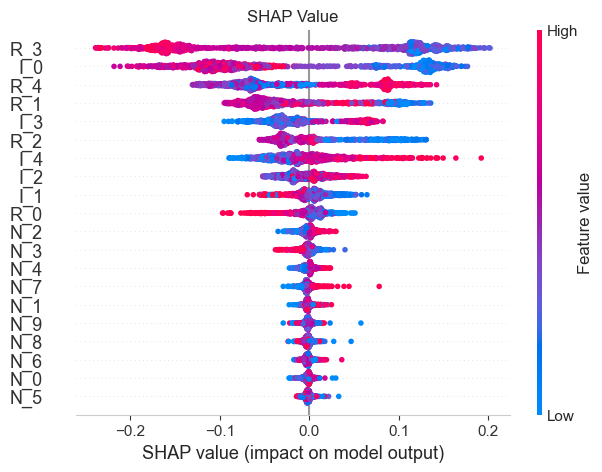

In [20]:
plt.grid(False)
plt.title('SHAP Value')
shap.plots.beeswarm(
    shap_values_train[:,:,1], 
    max_display = len(shap_values_train.feature_names),
    plot_size = (7, 5)
)
plt.show()

#### 3. Additional Models

여기서는 언급하지 않았지만, 설명가능 인공지능 모형에서는 다음과 같은 시도들이 이뤄지고 있다

1. Linear Double Machine Learning

Regression Model에 적합하며, linear Machine Learning 모형 두 개를 이용해 특정 변수의 **처치 효과(Treatment Effect)** 를 추정한다. 전통 통계학에서 2SLS의 방법론과 굉장히 유사하다

2. Causal Forest

Regression, Classification Model 둘 다 적용 가능하며, Linear DML과 같이 특정 변수의 처치효과를 추정한다. Dicision Tree 모형을 기반으로 한다는 점에서 차별된 점을 가지고 있다

3. LIME(Local Interpretable Model-agnostic Explanation)

국지적 설명력에 대해 다룬다. 모델의 종류와 무관하게 local variable의 효과에 대해 추정할 수 있다

4. LRP(계층별 타당성 전파; Layer-wise Relevance Propagation)

딥러닝 모형에 적합한 모형이다. 결괏값을 은닉층마다 분해하여 기여도를 계산 후 타당성 전파로 이전 은닉층에 재분배. 해당 기여도를 히트맵으로 시각화하여 어느 부분이 판단에 영향을 미쳤는지 확인한다. 계산에는 테일러 전개를 통해 값을 근사하는 방식을 이용한다